***Задание 3.1*. Прямоугольная металлическая пластина с вырезом используется как теплоотводящий элемент. В угловом вырезе пластины (границы $Г_2$ и $Г_3$) расположен источник тепла. Распределение температуры $T(x, y)$ по площади пластины описывается уравнением Лапласа:**

$$\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0$$

**Найдите распределение $T(x, y)$. Размеры $A, B, C$ и граничные условия даны в таблице.**



| Параметр          | Условия |
| ----------------- | ------- |
| $A$, мм           | 200     |
| $B$, мм           | 45      |
| $C$, мм           | 65      |
| $T(Г_1),^\circ C$ | 30      | 
| $T(Г_2),^\circ C$ | 60      |
| $T(Г_3),^\circ C$ | 60      |
| $T(Г_4),^\circ C$ | 30      |
| $T(Г_5),^\circ C$ | 20      |
| $T(Г_6),^\circ C$ | 20      |

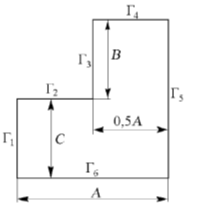

In [1]:
from IPython.display import Image
Image("plate.png")

### Постановка задачи:

В данном задании описана задача Дирихле, собственно, ее решением и будем заниматься.

Найти решение уравнения Лапласа $\Delta T = 0$, удовлетворяющее условиям.

$T_{Г_6}(x, 0) = 20$

$T_{Г_5}(A, y) = 20$

$T_{Г_4}(x, C + B) = 30, \frac{A}{2} \leq x \leq A$

$T_{Г_3}(\frac{A}{2}, y) = 60, C \leq y \leq C + B$

$T_{Г_2}(x, C) = 60, 0 \leq x \leq \frac{A}{2}$

$T_{Г_1}(0, y) = 30, 0 \leq y \leq C$

Преобразование нашего уравнения эллиптического типа производится путем замены прозиводных второго порядка конечно-разностными формулами.

$$\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0 \Rightarrow \frac{T_{i+1, j} - 2T_{i, j} + T_{i - 1, j}}{\Delta x^2} + \frac{T_{i, j + 1} - 2T_{i, j} + T_{i, j - 1}}{\Delta y^2} = 0$$

$i$, $j$ отсчитываются соответственно по осям $x$, $y$

Построим сетку для аппроксимации уравнения $\Delta T = 0$:

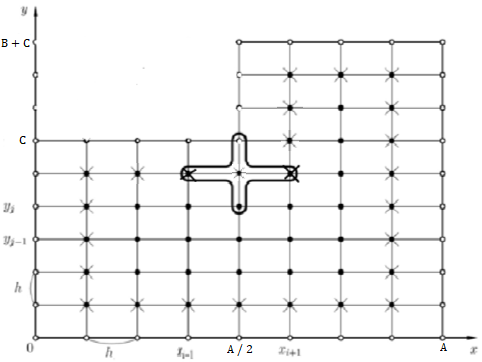

In [2]:
Image("grid.png")

### Используемый метод

Будем использовать итерационный метод, поэтому для начала берем метод Зейделя, так как он проще в реализации. Потом можем в случае чего взять метод релаксации. Метод перменных направлений

Запишем метод для нашей формулы:

$$\frac{T^{k}_{i+1, j} - 2T^{k + 1}_{i, j} + T^{k + 1}_{i - 1, j}}{\Delta x^2} + \frac{T^{k}_{i, j + 1} - 2T^{k + 1}_{i, j} + T^{k + 1}_{i, j - 1}}{\Delta y^2} = 0,  \Delta x^2 = \Delta y^2 = h^2$$

Выразим $T^{k + 1}_{i, j}$:

$$T^{k + 1}_{i, j} = \frac{T^{k}_{i+1, j} + T^{k + 1}_{i - 1, j} + T^{k}_{i, j + 1} + T^{k + 1}_{i, j - 1}}{2 \cdot 2} = \frac{T^{k}_{i+1, j} + T^{k + 1}_{i - 1, j} + T^{k}_{i, j + 1} + T^{k + 1}_{i, j - 1}}{4}$$

Будем завершать процесс при достижении заданной точности $\epsilon$, для этого используем разницу между двумя ближайшими итерациями в Евклидовой норме.

$$\| x \|_2 = \sqrt{\sum_{i = 1}^n |T^{k + 1}_i - T^{k}_i|^2}$$

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [124]:
A = 20.
B = 6.5
C = 4.5
h = 0.5

boundary_values = np.array([30., 60., 60., 30., 20., 20.])

x_count = int(A / h) + 1
y_count = int((C + B) / h) + 1

eps = 0.01

def initialize_matrix(A, B, C, boundary_values, x_count, y_count):
    matrix = np.zeros((y_count, x_count))
    
    matrix[int(C / h) + 1:, 0] = boundary_values[0]
    matrix[int(C / h) + 1, :int(A / (2 * h)) + 1] = boundary_values[1]
    matrix[:int(C / h) + 2, int(A / (2 * h)) + 1] = boundary_values[2]
    matrix[0, int(A / (2 * h)) + 2:] = boundary_values[3]
    matrix[:, int(A /  h)] = boundary_values[4]
    matrix[int((C + B) / h), :] = boundary_values[5]
    
    return matrix

matrix = initialize_matrix(A, B, C, boundary_values, x_count, y_count)

In [125]:
def T1(A, B, C, h, T0, y_count, x_count):
        T1 = np.copy(T0)
        for i in range(1, y_count):
            for j in range(1, x_count):
                if j > (int(A / (2 * h)) + 1) or i > (int(C / h) + 1):
                    T1[i, j] = (T0[i - 1, j] + T1[i + 1, j] + T0[i, j + 1] + T1[i, j - 1]) / 4

        return T1
    
def Norm(T_k1, T_k):
        diff = np.abs(T_k1 - T_k)
        return np.sqrt(np.sum(diff ** 2) / len(diff))

def method_Zeidel(A, B, C, h, y_count, x_count, eps, matrix):
    T_k = T_k1 = matrix
    iterations = 0
    norm = 1000
    norms = []
    while norm >= eps:
        iterations += 1
        T_k = T_k1
        T_k1 = T1(A, B, C, h, T_k, y_count, x_count)
        norm = Norm(T_k1, T_k)
        norms.append(norm)
    return T_k1, iterations, np.array(norms)

T, iterations, norms = method_Zeidel(A, B, C, h, y_count - 1, x_count - 1, eps, matrix)

print(iterations)

356


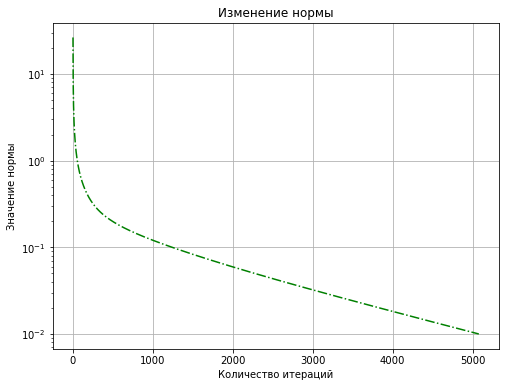

0.009999045684964047


In [119]:
i = np.arange(len(norms))
plt.figure(figsize=(8, 6))
plt.title("Изменение нормы")
plt.plot(i, norms[i], 'g-.')
plt.xlabel('Количество итераций')
plt.ylabel('Значение нормы')
plt.yscale('log')
plt.grid()
plt.show()

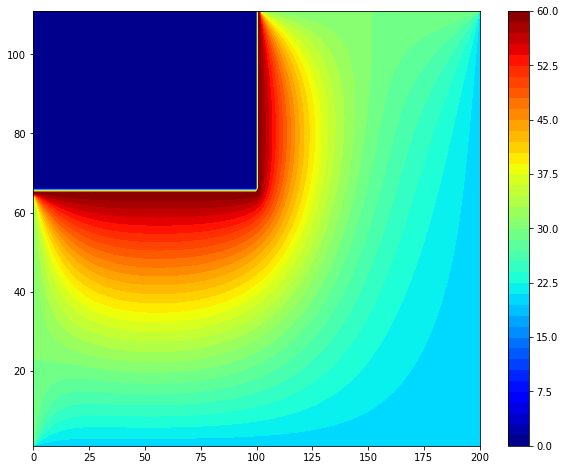

In [120]:
X, Y = np.meshgrid(np.arange(0, x_count), np.arange(y_count, 0, -1))
plt.figure(figsize = (10, 8))
colorinterpolation = 50
colourMap = plt.cm.jet
plt.contourf(X, Y, T, colorinterpolation, cmap=colourMap)
plt.colorbar()
plt.show()

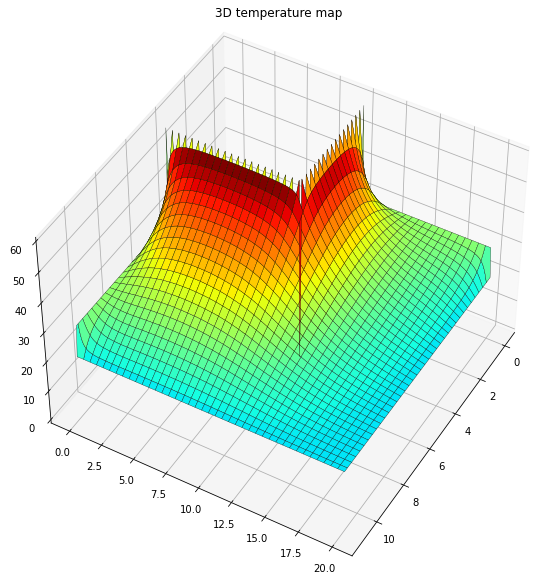

In [121]:
# %matplotlib notebook
xgrid, ygrid = np.meshgrid(np.linspace(0., A, x_count), np.linspace(0., B + C , y_count))

fig = plt.figure(figsize=(15, 10))
axes = fig.add_subplot(projection='3d')
axes.set_title('3D temperature map')

axes.plot_surface(ygrid, xgrid, T, cmap = 'jet',linewidth=0.3, edgecolors='k')
axes.view_init(elev=45, azim=30)

plt.show()

### Тестовые примеры

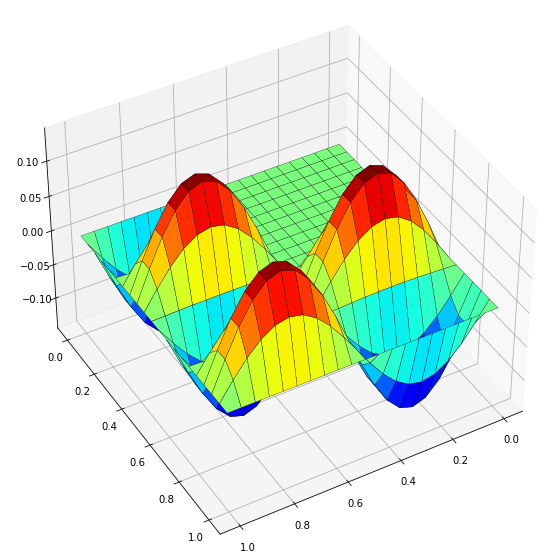

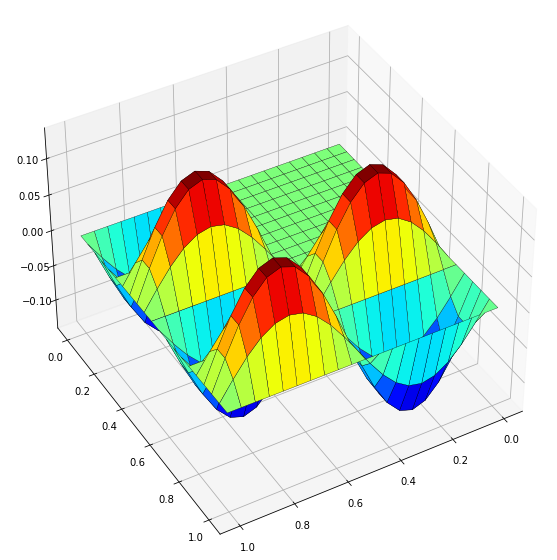

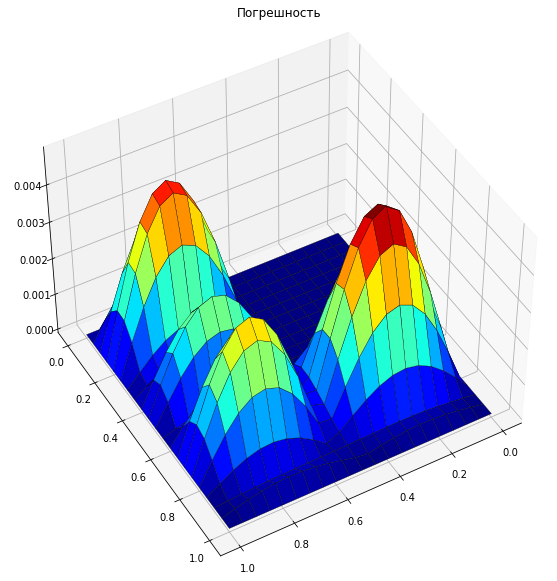

In [129]:
A_test = 1
B_test = 0.5
C_test = 0.5
h_test = 0.05

x_count_test = int(A_test / h_test) + 1
y_count_test = int((C_test + B_test) / h_test) + 1

boundary_values_test = np.array([0., 0., 0., 0., 0., 0.])

def initialize_matrix(A, B, C, boundary_values, x_count, y_count):
    matrix = np.zeros((y_count, x_count))
    
    matrix[int(C / h) + 1:, 0] = boundary_values[0]
    matrix[int(C / h) + 1, :int(A / (2 * h)) + 1] = boundary_values[1]
    matrix[:int(C / h) + 2, int(A / (2 * h)) + 1] = boundary_values[2]
    matrix[0, int(A / (2 * h)) + 2:] = boundary_values[3]
    matrix[:, int(A /  h)] = boundary_values[4]
    matrix[int((C + B) / h), :] = boundary_values[5]
    
    return matrix

matrix_test = initialize_matrix(A_test, B_test, C_test, boundary_values_test, x_count_test, y_count_test)

def test_f(x, y):
#     return -85 * (np.pi ** 2) * np.sin(4 * np.pi * x) * np.sin(np.pi * y) / 12
    return -20 * (np.pi ** 2) * np.sin(4 * np.pi * x) * np.sin(2 * np.pi * y) / 7

def exact_f(x, y):
#     return 5 * np.sin(4 * np.pi * x) * np.sin(np.pi * y) / 12
    return np.sin(4 * np.pi * x) * np.sin(2 * np.pi * y) / 7

def Norm(T_k1, T_k):
        diff = np.abs(T_k1 - T_k)
        return np.sqrt(np.sum(diff ** 2) / len(diff))

def T1_exact(A, B, C, h, T0, y_count, x_count, f):
    
    T1_exact = np.copy(T0)
    for i in range(1, y_count):
        for j in range(1, x_count):
            if j > (int(A / (2 * h))) or i > (int(C / h)):
                T1_exact[i, j] = f(j * h, i * h)
                
    return T1_exact

def exact_solution(A, B, C, h, y_count, x_count, eps, matrix, f):
    T_k = T_k1 = matrix
    T_k1 = T1_exact(A, B, C, h, T_k, y_count, x_count, f)
    
    return T_k1
    
def T1_test(A, B, C, h, T0, y_count, x_count, f):
        T1_test = np.copy(T0)
        for i in range(1, y_count):
            for j in range(1, x_count):
                if j > (int(A / (2 * h))) or i > (int(C / h)):
                    T1_test[i, j] = (-f(j * h, i * h) * (h ** 2) + T0[i - 1, j] + T1_test[i + 1, j] + 
                                     T0[i, j + 1] + T1_test[i, j - 1]) / 4

        return T1_test

def method_test(A, B, C, h, y_count, x_count, eps, matrix, f):
    T_k = T_k1 = matrix
    iterations = 0
    norm = 1000
    norms = []
    while norm >= eps:
        iterations += 1
        T_k = T_k1
        T_k1 = T1_test(A, B, C, h, T_k, y_count, x_count, f)
        norm = Norm(T_k1, T_k)
        norms.append(norm)
    return T_k1, iterations, np.array(norms)

eps = 0.001

T_test, iterations_test, norms_test = method_test(A_test, B_test, C_test, h_test, y_count_test - 1, x_count_test - 1, 
                                                  eps, matrix_test, test_f)

exact = exact_solution(A_test, B_test, C_test, h_test, y_count_test - 1, x_count_test - 1, eps, matrix_test, exact_f)

xgrid_test, ygrid_test = np.meshgrid(np.linspace(0., A_test, x_count_test), np.linspace(0., B_test + C_test , y_count_test))

# test
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(ygrid_test, xgrid_test, T_test, cmap = 'jet',linewidth=0.3, edgecolors='k')
ax.view_init(elev=40, azim=60)

# exact
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(ygrid_test, xgrid_test, exact, cmap = 'jet',linewidth=0.3, edgecolors='k')
ax.view_init(elev=40, azim=60)

# difference
diff_test = np.abs(T_test - exact)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_title('Погрешность')
ax.plot_surface(ygrid_test, xgrid_test, diff_test, cmap = 'jet',linewidth=0.3, edgecolors='k')
ax.view_init(elev=45, azim=60)

plt.show()